<a href="https://colab.research.google.com/github/rocioparra/redes-neuronales/blob/master/02-naive-bayes/RN20202Q_NaiveBayes_Parra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset: Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) es un dataset con imágenes de prendas de vestir (artículos de la compañía Zalando). Son 70000 imágenes en baja resolución (28x28 pixeles), en escala de grises, agrupadas en 10 clases. Se utiliza en la comunidad de Machine Learning para comparación de algoritmos, de la misma forma que el dataset MNIST.

In [1]:
from sklearn.datasets import fetch_openml 
import os.path
import pickle
import numpy as np

MNIST_FILE = 'mnist.p'

if os.path.isfile(MNIST_FILE):
    X, y = pickle.load(open(MNIST_FILE, 'rb'))
else:
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
    y = y.astype(int)
    pickle.dump((X, y), open(MNIST_FILE, 'wb'))

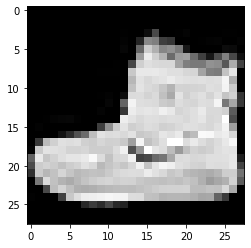

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(X[0].reshape(28, 28), cmap="gray")
plt.show()

El objetivo de esta práctica es utilizar la técnica de Naive Bayes como clasificador de imágenes, preparando una notebook para obtener las respuestas del cuestionario en Campus

In [3]:
label_dict = {
    i: article for i, article in enumerate(
    ['T-shirt/top', 
     'Trouser',
     'Pullover',
     'Dress',
     'Coat',
     'Sandal',
     'Shirt',
     'Sneaker',
     'Bag',
     'Ankle boot']
    )
}

### Consignas a resolver

- Redimensionar los datos de entrada con la dimensión de las imágenes

In [4]:
H = 28
W = 28
X = X.reshape(-1, H, W)

- Graficar las primeras 150 imágenes como una grilla. 


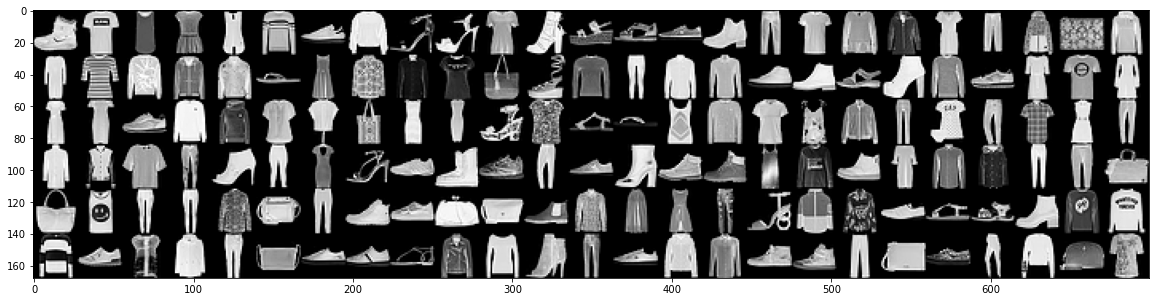

In [5]:
from helper import img_grid
img_grid(X[:150], n_rows=6)

- Graficar las primeras 100 imágenes de cada clase

Ankle boot


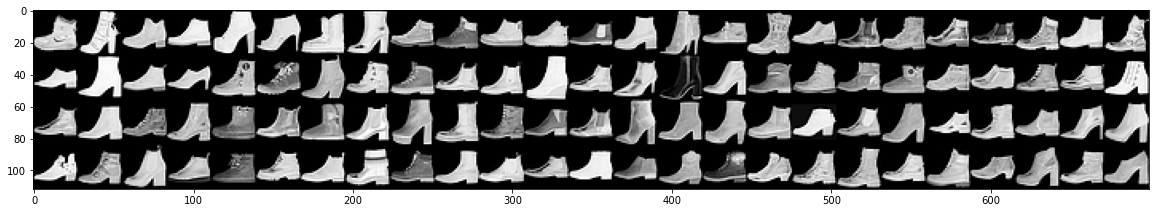

T-shirt/top


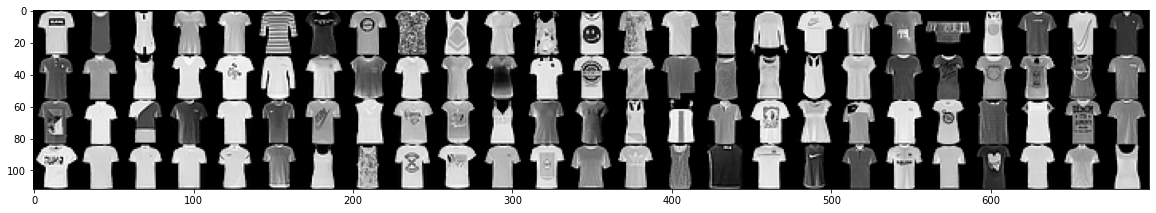

Dress


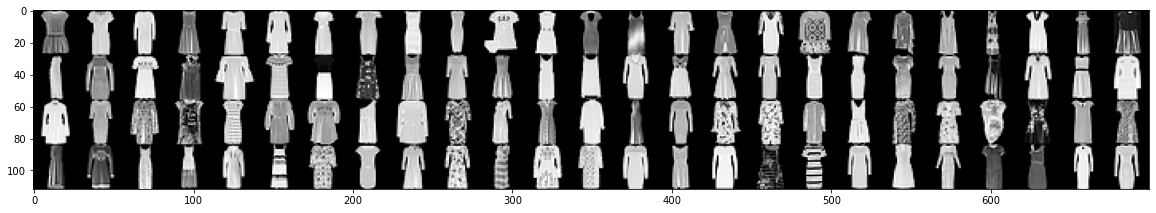

Pullover


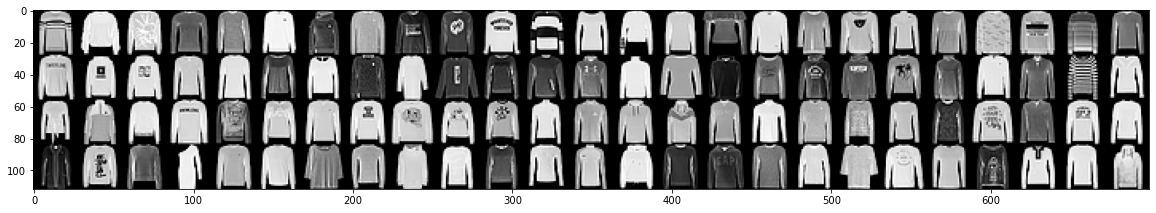

Sneaker


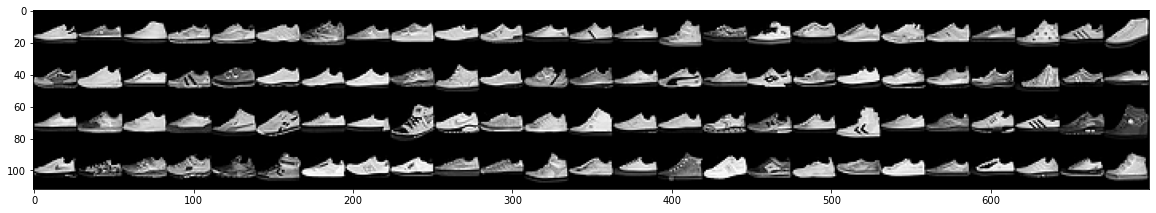

Sandal


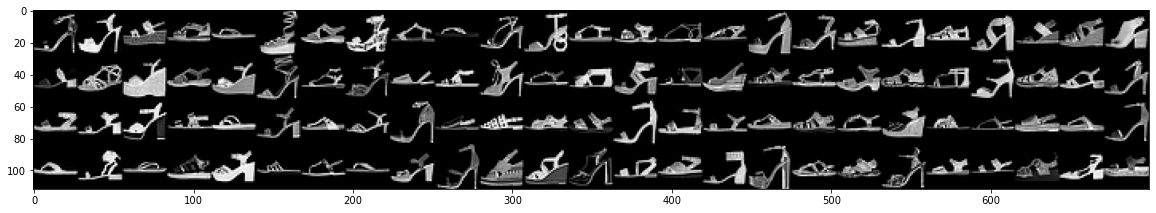

Trouser


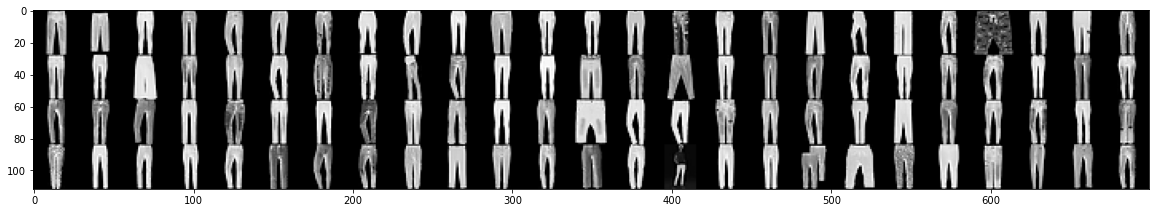

Shirt


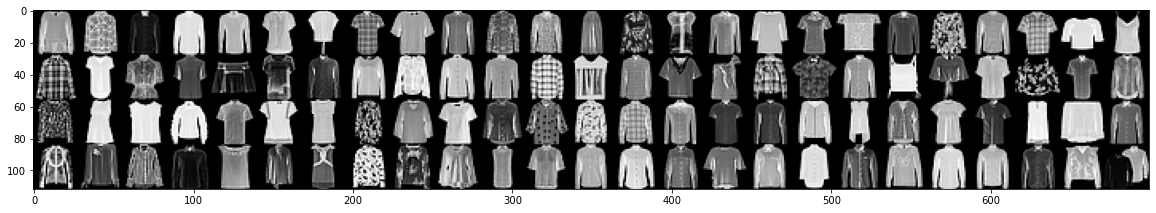

Coat


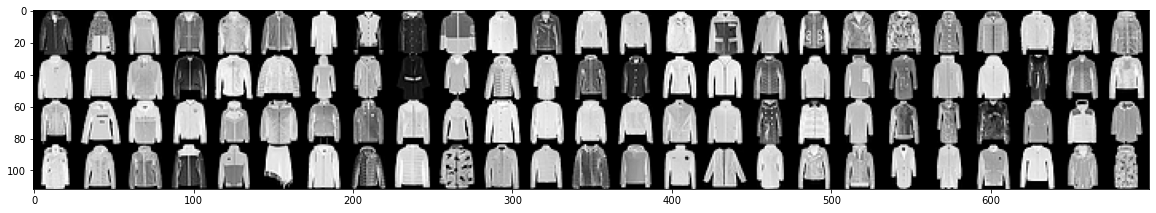

Bag


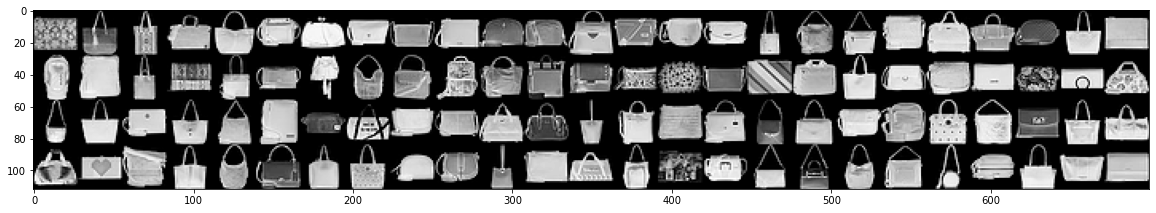

In [6]:
from collections import defaultdict

# classify by type of clothing
clothes = defaultdict(list)
for i, article in enumerate(y):
    clothes[label_dict[article]].append(X[i])

# show grid with 100 first imgs of each article
for article in clothes:
    clothes[article] = np.array(clothes[article])
    print(article)
    img_grid(clothes[article][:100], n_rows=4)

**Split train-validation**

- Dividir los datos en train, validation y test, en un ratio 5:1:1, usando **random_state=42**. De forma estratificada por clases

Función útil: *sklearn.model_selection.train_test_split*



In [7]:
from sklearn.model_selection import train_test_split

ratios = (5, 1, 1)  # train / validation / test

# get test set
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, random_state=42, stratify=y,
    test_size=ratios[2]/sum(ratios)
)

# split remainder between train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, random_state=42, stratify=y_train_valid,
    test_size=ratios[1]/sum(ratios[:2])
)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_valid)}')
print(f'Test size: {len(X_test)}')                                                        

Train size: 50000
Validation size: 10000
Test size: 10000


## Naive Bayes Multinomial

Vamos a construir un clasificador de imágenes para el dataset Fashion MNIST usando el método de Naive Bayes Multinomial

- Construir un histograma de 255 bins para la distribución del nivel de gris del pixel [15,15] en imágenes de clase “Dress”.

Función útil: *plt.hist()*

In [8]:
from helper import clothes_dict

In [9]:
# classify clothes in train
clothes_train = clothes_dict(names=y_train, pics=X_train.reshape(-1, 28, 28))

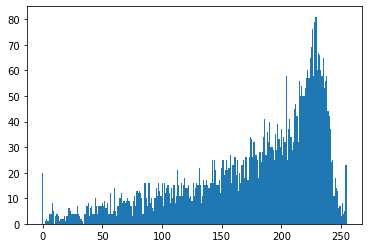

Frecuencia de G=147: 15


In [10]:
hist, bins = np.histogram(clothes_train['Dress'].from_pxls[15][15], bins=255)
plt.bar(x=bins[:-1], height=hist, width=1)
plt.show()

print(f"Frecuencia de G=147: {hist[147]}")

- Calcular la probabilidad a priori de la clase "Dress"

In [11]:
dress = clothes_train['Dress']
print(dress.priori)

0.1


- Calcular el likelihood del nivel de gris $x_g=147$ para la clase 'Dress', utilizando 255 niveles de gris

In [12]:
hist255 = np.histogram(dress.from_pxls[15][15], bins=255, density=True)[0] 
print(hist255[147])

0.003


- Calcular el likelihood del nivel de gris $x_g=147$ para la clase 'Dress', utilizando 10 niveles de gris

In [13]:
hist10 = np.histogram(dress.from_pxls[15][15], bins=10, density=True)[0]
print(f"{hist10[147*10//256]:.3}")

0.0033


### - Crear una matriz de 28x28x10 que tenga los likelihoods de cada posición para cada clase 

In [14]:
for article in clothes_train.values():
    article.likelihood = np.array(
        [[np.histogram(article.from_pxls[i][j], 10)[0]/len(article)
        for j in range(W)] for i in range(H)]
    )

- ¿Cuál es la probabilidad a posteriori no normalizada de que un pixel con $x_g=124$ en la posición $[17,17]$ pertenezca a la clase "Bag"? 

In [15]:
clothes_train['Bag'].likelihood[17][17][(124*10)//256]

0.0662

### Clasificador NBM y búsqueda de hiperparámetros:

Ajustar un modelo NBM a los datos de X_train, y realizar una búsqueda por grilla de hiperparámetros, utilizando los datos de X_valid para calcular el desempeño del modelo con cada combinación de hiperparámetros.

Probar los siguientes valores de hiperparámetros y sus posibles combinaciones:

- Cantidad de niveles de gris: {10, 64, 128, 255}

- Smoothing: Alfa={0.1,0.01,0.001,0.0001}

- Agrupamiento de píxeles: dimensión del grupo={[1,1],[2,2],[2,1],[4,4]}

Método:

*sklearn.naive_bayes.MultinomialNB*



In [16]:
grey_levels = (10, 256)
alphas = (1e-3, 1e-5, 1e-7)
group_sizes = tuple(np.array(size) for size in ([1,1], [2,2]))                   


In [17]:
X_train = X_train.reshape(-1, H*W)
X_valid = X_valid.reshape(-1, H*W)
X_test = X_test.reshape(-1, H*W)

In [18]:
def getExpandido(x, w, h):
    """Funcion para agrupar píxeles por grupos.
    Debe tomar un conjunto X de N matrices de HxW, y devuelve un nuevo conjunto
     X_expandido de N*width*height matrices de HxW según lo visto en la presentación
    Pasos:
    1. Si X es unidimensional, reshapearlo a matrices
    2. Muestrear cada matriz para generar width*height matrices de menor dimensión (H/height x W/width)
    3. Concatenar estas matrices
    4. Repetir cada pixel para llevar las matrices a la dimension original HxW

    Funciones útiles: -samplear vectores por paso
                      -np.concatenate()
                      -np.repeat()
    """
    x = x.reshape(-1, H // h, h, W // w, w)  # split each img into h*w groups
    x = x.swapaxes(1, 2).swapaxes(2, 4).swapaxes(3, 4)  # split groups
    x = x.reshape(-1, H // h, W // w)  # split each img into h*w images
    x = x.repeat(h, axis=1).repeat(w, axis=2)  # resize images
    return x.reshape(-1, H * W)

Original


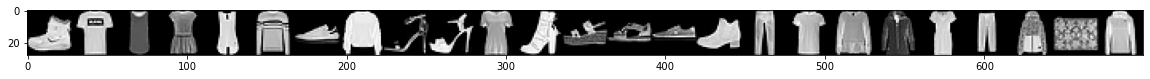

Expandido, 2x2


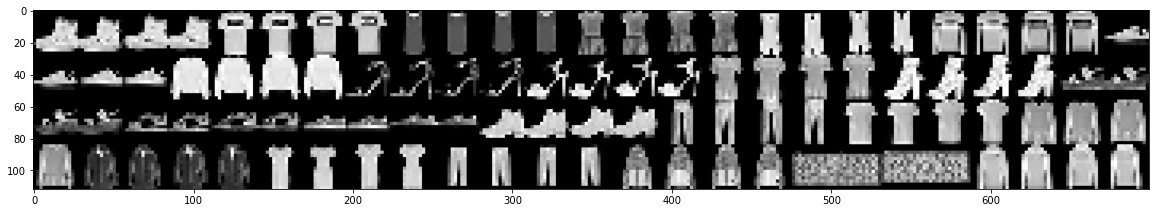

In [19]:
imgs = X[:25]
imgs_exp = getExpandido(imgs, 2, 2)
print('Original')
img_grid(imgs, 1)
print('Expandido, 2x2')
img_grid(imgs_exp, 4)

In [25]:
def getNewGrayLevels(x, bins):
    """
    Función que transforme los valores de gris de x
    para llevarlos a una nueva escala con len(bins) valores de gris,
    donde cada elemento de bins es un valor de la escala.

    """
    if bins == 256:
        return x
    delta = 255 / (bins - 1)  # new minimum diff between two values
    return np.trunc((x // delta) * delta) # round x to multiples of delta

Original


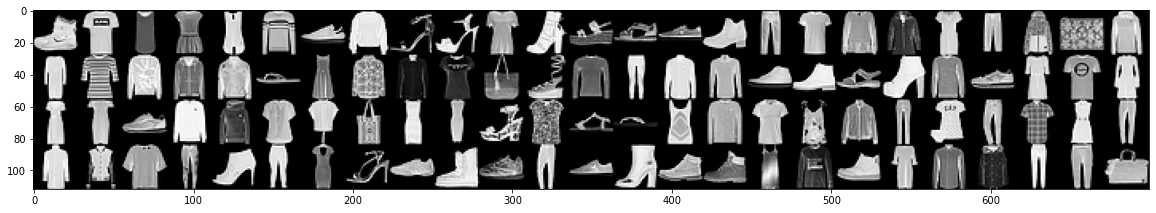

Con 10 niveles de gris


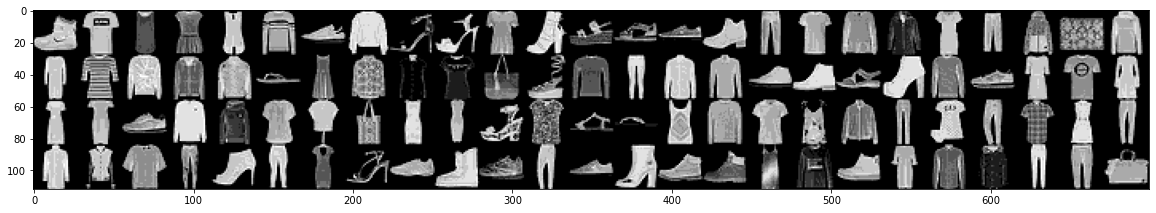

In [26]:
imgs = X[:100]
imgs10 = getNewGrayLevels(imgs, 10)
print('Original')
img_grid(imgs, 4)
print('Con 10 niveles de gris')
img_grid(imgs10, 4)

In [27]:
#Guardar las versiones de matrices con distintas escalas de niveles de gris, porque tardan en procesarse

x_train_g = {}
x_valid_g = {}
for grey in grey_levels:
    x_train_g[grey] = getNewGrayLevels(X_train, grey)
    x_valid_g[grey] = getNewGrayLevels(X_valid, grey)


In [28]:
# Recorrer todas las combinaciones de escalas, grupos de pixeles y alfas,registrando el accuracy en 
#validacion

from sklearn.naive_bayes import MultinomialNB
import pandas as pd

OUT_FILE = 'out3.csv'

total_its = len(grey_levels)*len(group_sizes)*len(alphas)
i = 1

if os.path.isfile(OUT_FILE):
    accuracies = pd.read_csv(OUT_FILE)
else:
    accuracies = []
    
    for grey in grey_levels:
        
        for size in group_sizes:
            x = getExpandido(x_train_g[grey], *size)
            y = y_train.repeat(size[0] * size[1])

            for alpha in alphas:
                print(f'Computing: G={grey}, S={size}, A={alpha} ({i}/{total_its})...')
                i += 1
                
                clf = MultinomialNB(alpha=alpha)
                clf.fit(x, y)

                accuracy = clf.score(x_valid_g[grey], y_valid)
                accuracies.append({
                    'Grey levels': grey,
                    'Alpha': alpha,
                    'Pixel grouping': size,
                    'Accuracy': accuracy
                })

                print(f'Accuracy: {accuracy}')
                print(50 * '-')
    
    accuracies = pd.DataFrame(accuracies)
    accuracies.to_csv(OUT_FILE, index=False)

Computing: G=10, S=[1 1], A=0.001 (1/12)...
Accuracy: 0.67
--------------------------------------------------
Computing: G=10, S=[1 1], A=1e-05 (2/12)...
Accuracy: 0.67
--------------------------------------------------
Computing: G=10, S=[1 1], A=1e-07 (3/12)...
Accuracy: 0.6701
--------------------------------------------------
Computing: G=10, S=[2 2], A=0.001 (4/12)...
Accuracy: 0.6581
--------------------------------------------------
Computing: G=10, S=[2 2], A=1e-05 (5/12)...
Accuracy: 0.6581
--------------------------------------------------
Computing: G=10, S=[2 2], A=1e-07 (6/12)...
Accuracy: 0.6581
--------------------------------------------------
Computing: G=256, S=[1 1], A=0.001 (7/12)...
Accuracy: 0.6671
--------------------------------------------------
Computing: G=256, S=[1 1], A=1e-05 (8/12)...
Accuracy: 0.6671
--------------------------------------------------
Computing: G=256, S=[1 1], A=1e-07 (9/12)...
Accuracy: 0.6671
--------------------------------------------

In [30]:
accuracies

,Grey levels,Alpha,Pixel grouping,Accuracy
0,10,1.000000e-03,"[1, 1]",0.6700
1,10,1.000000e-05,"[1, 1]",0.6700
2,10,1.000000e-07,"[1, 1]",0.6701
3,10,1.000000e-03,"[2, 2]",0.6581
4,10,1.000000e-05,"[2, 2]",0.6581
5,10,1.000000e-07,"[2, 2]",0.6581
6,256,1.000000e-03,"[1, 1]",0.6671
7,256,1.000000e-05,"[1, 1]",0.6671
8,256,1.000000e-07,"[1, 1]",0.6671
9,256,1.000000e-03,"[2, 2]",0.6543


### Testeo

- Clasificar los datos de test con el modelo que dió mejor accuracy en validación. 

- Reportar accuracy en test. 


In [31]:
best = accuracies['Accuracy'].max()
best_filt = accuracies['Accuracy'] == best
best_hypers = accuracies[best_filt]
best_hypers

,Grey levels,Alpha,Pixel grouping,Accuracy
2,10,1.000000e-07,"[1, 1]",0.6701


In [32]:
best_hyper = best_hypers.iloc[0]
size = best_hyper['Pixel grouping']
x = getExpandido(x_train_g[best_hyper['Grey levels']], 
                 size[0], size[1])
y = y_train.repeat(size[0] * size[1])

clf = MultinomialNB(alpha=best_hyper['Alpha'])
clf.fit(x, y)

test_accuracy = clf.score(getNewGrayLevels(X_test, best_hyper['Grey levels']), y_test)
test_accuracy

0.6622

## Naive Bayes Gaussiano

- Graficar la distribución normal del pixel (10,10) de la clase 'Trouser' y de la clase 'Pullover'

Función útil:

*scipy.stats.norm.pdf*

In [ ]:
m = clothes_train['Trouser'].from_pxls[10][10].mean()
s = clothes_train['Trouser'].from_pxls[10][10].std()

from scipy.stats import norm
trouser1010 = norm(m, s)

x = np.linspace(-100, 300, endpoint=True)
y = trouser1010.pdf(x)
plt.vlines(x=[0, 255], ymin=0, ymax=0.007, linewidth=1.2,
          linestyles='solid', color='grey')
plt.vlines(x=[m-s, m, m+s], ymin=0, ymax=0.007, linewidth=1.2,
           linestyles='dashed', color={'blue','grey', 'blue'})
plt.plot(x, y)
plt.title('Pixel (10, 10)')
plt.show()

- *¿Cuál es la media y el desvío estándar del pixel (14,14) en la clase 'Bag' estimados a partir del set de train?*

In [ ]:
m = clothes_train['Bag'].from_pxls[14][14].mean()
s = clothes_train['Bag'].from_pxls[14][14].std()

print(f"Media = {m:.5}\nDesvío = {s:.4}")

- Armar una matriz con la media y el desvío para cada pixel y para cada clase. Tendrá dimensión (2x784x10)

In [ ]:
for article in clothes_train.values():
    article.means = article.from_pxls.mean(axis=2)
    article.stds = article.from_pxls.std(axis=2)

**Complejidad del modelo**

#### *¿Cuántos parámetros tendrá el modelo de Naive Bayes Gaussiano dado que se asumió independencia entre los píxeles?*

El modelo tendrá los siguientes parámetros:
- 10 parámetros correspondientes a probabilidades a priori de las clases
- $28\cdot28=784$ pares de media y varianza para cada clase, correspondientes a la distribución de probabilidad del valor de gris de cada píxel

Por lo tanto, en total hay $10+10\cdot784\cdot2= 15690$ parámetros.

#### *Si no se asume independencia, es decir que las covarianzas entre variables no se desprecian: ¿cuántos parámetros tendría el modelo?* 

En este caso, ya no bastaría contar con la varianza de cada píxel de cada clase, sino que además habría que obtener la correlación entre cada par de píxeles de una misma clase. Es decir, para cada clase se tendría:
- Un vector de medias, con 784 elementos
- Una matriz de covarianzas de $784\cdot784$. Sin embargo, esta matriz sería simétrica, con lo cual se podría determinar a partir de los valores de la diagonal (varianzas) y del triángulo superior o inferior (covarianzas), con lo cual los parámetros contenidos en cada matriz serían $784+\frac{784*(784-1)}{2}$ (_la matriz tiene un total de 784·784 elementos, de los cuales 784 están en la diagonal, y por lo tanto 784·(784-1)/2, la mitad del resto de los elementos, están en cada uno de los triángulos)_.

Por lo tanto, la cantidad total de parámetros sería 
$$
    \underbrace{10}_{\text{prioris}} + \underbrace{784}_{\vec\mu} + \underbrace{784+\frac{784\cdot (784-1)}{2}}_{\Sigma} = 308514 \text{ parámetros}
$$

Es decir, la cantidad de parámetros es casi 20 veces más grande que considerando independencia entre píxeles.

## Naive Bayes Gaussiano como clasificador

Ajustar un modelo NBG a los datos de X_train, y realizar una búsqueda por grilla de hiperparámetros, utilizando los datos de X_valid para calcular el desempeño del modelo con cada combinación de hiperparámetros.

Probar los siguientes valores de hiperparámetros y sus posibles combinaciones:

- Variance Smoothing ={1,0.1,0.001,0.00001,0.0000001}

- Agrupamiento de píxeles: dimensión del grupo={[1,1],[2,2],[2,1],[4,4]}

Función útil:

*sklearn.naive_bayes.GaussianNB*

In [84]:
from sklearn.naive_bayes import GaussianNB

OUT_FILE_GAUSS = 'out_gauss10.csv'


var_smooths=(1, 0.1, 0.001, 0.00001, 0.0000001)


if os.path.isfile(OUT_FILE_GAUSS):
    accuracies_gaussian = pd.read_csv(OUT_FILE_GAUSS)
else:
    accuracies_gaussian = []
    
    total_its = len(group_sizes)*len(var_smooths)
    i = 1

    for size in group_sizes:
        x = getExpandido(x_train_g[10], *size)
        y = y_train.repeat(size[0] * size[1])

        for smoothing in var_smooths:
            print(f'Computing: SIZE={size}, SMOOTHING={smoothing} ({i}/{total_its})...')
            i += 1

            clf = GaussianNB(var_smoothing=smoothing)
            clf.fit(x, y)

            accuracy = clf.score(x_valid_g[10], y_valid)
            accuracies_gaussian.append({
                'Smoothing': smoothing,
                'Pixel grouping': size,
                'Accuracy': accuracy
            })

            print(f'Accuracy: {accuracy}')
            print(50 * '-')

    accuracies_gaussian = pd.DataFrame(accuracies_gaussian)
    accuracies_gaussian.to_csv(OUT_FILE_GAUSS, index=False)

Computing: SIZE=[1 1], SMOOTHING=1 (1/10)...
Accuracy: 0.6297
--------------------------------------------------
Computing: SIZE=[1 1], SMOOTHING=0.1 (2/10)...
Accuracy: 0.6609
--------------------------------------------------
Computing: SIZE=[1 1], SMOOTHING=0.001 (3/10)...
Accuracy: 0.6419
--------------------------------------------------
Computing: SIZE=[1 1], SMOOTHING=1e-05 (4/10)...
Accuracy: 0.6176
--------------------------------------------------
Computing: SIZE=[1 1], SMOOTHING=1e-07 (5/10)...
Accuracy: 0.5943
--------------------------------------------------
Computing: SIZE=[2 2], SMOOTHING=1 (6/10)...
Accuracy: 0.6108
--------------------------------------------------
Computing: SIZE=[2 2], SMOOTHING=0.1 (7/10)...
Accuracy: 0.6256
--------------------------------------------------
Computing: SIZE=[2 2], SMOOTHING=0.001 (8/10)...
Accuracy: 0.6074
--------------------------------------------------
Computing: SIZE=[2 2], SMOOTHING=1e-05 (9/10)...
Accuracy: 0.5849
----------

In [85]:
accuracies_gaussian

,Smoothing,Pixel grouping,Accuracy
0,1.000000e+00,"[1, 1]",0.6297
1,1.000000e-01,"[1, 1]",0.6609
2,1.000000e-03,"[1, 1]",0.6419
3,1.000000e-05,"[1, 1]",0.6176
4,1.000000e-07,"[1, 1]",0.5943
5,1.000000e+00,"[2, 2]",0.6108
6,1.000000e-01,"[2, 2]",0.6256
7,1.000000e-03,"[2, 2]",0.6074
8,1.000000e-05,"[2, 2]",0.5849
9,1.000000e-07,"[2, 2]",0.5646


### Testeo

- Clasificar los datos de test con el modelo que dió mejor accuracy en validación. 

- Reportar accuracy en test. 

In [86]:
best_g = accuracies_gaussian['Accuracy'].max()
best_g_filt = accuracies_gaussian['Accuracy'] == best_g
best_hyper = accuracies_gaussian[best_g_filt]
best_hyper = best_hyper.iloc[0]
best_hyper

Smoothing            0.1
Pixel grouping    [1, 1]
Accuracy          0.6609
Name: 1, dtype: object

In [90]:
# best_size = np.array([int(i) for i in best_hyper['Pixel grouping'][1::2]])
best_size = best_hyper['Pixel grouping']
x = getExpandido(X_train, best_size[0], best_size[1])
y = y_train.repeat(best_size[0] * best_size[1])

clf = GaussianNB(var_smoothing=best_hyper['Smoothing'])
clf.fit(x, y)
test_accuracy = clf.score(X_test, y_test)
test_accuracy

0.6708

- Calcular cuántos parámetros tiene el modelo para cada valor de pixels_per_group

Como las imágenes mantienen su tamaño, la cantidad de parámetros no se ve afectada.